# Data processing and stochastic modelization

In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

import math

#Home made functions
import Utilities

#####Reference values and ranges for filename generation#####
UREF = 4.6E-06 #[m/s]
TREF = 2.92E+01 #[s]
LSAMP = 3.0E-03 #[m]
LPORE = LSAMP/22.6 #[m]
RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.pdf' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/PDM/data/' #On laptop
FDIR = '../report/Figures/' #Figure directory
ODIR = DIR + 'Processed_data/' #Output directory
CASE   = 'Bentheimer1000'

In [2]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        if v_ == 'Inf' : v_ = 0
        p_dict[p_] = float(v_)
    return p_dict

def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    #data_ = data_[~np.isnan(data_)]
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_

def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return r'$\infty$'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [3]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

#### Data files 

In [4]:
DATA = {}

SAMPLE = 'Bentheimer 1000'
PECLET = [0, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1]
SLSM   = [20000, 20000, 20000, 20000, 20000, 20000, 20000]
CSF    = [1, 1, 1, 1, 1, 1, 1]
KEYS   = []
for (Pe_, slsm_, csf_) in zip(PECLET, SLSM, CSF) : 
    name_ = DIR+CASE+'/Particle_Tracking/sl_out_Pe'+v_to_s(Pe_)+'_SLSM'+v_to_s(slsm_)+'_TMAX0_CSF'+str(csf_)+'.dat'
    key_  = 'Pe='+v_to_pow(Pe_)+', SLSM='+v_to_pow(slsm_)+', CSF='+str(csf_)
    DATA[key_] = name_
    KEYS.append(key_)

PLOT_KEYS = KEYS

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

PARAM = {}
param = ['Pe','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
    
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 7


# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [5]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(ODIR+'UMEAN'+str(Ndat)+'.dat')) :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,ODIR+'UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(ODIR+'UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [6]:
vDNS = {}; 
vfname    = ODIR+'vDNS.dat'
if os.path.isfile(vfname)    and (not RERUN) : 
    print('Loading vDNS..')
    vDNS     = Load_data(vfname)

Loading vDNS..


In [7]:
tDNS = {};    
tfname    = ODIR+'tDNS.dat'
if os.path.isfile(tfname)    and (not RERUN) : 
    print('Loading tDNS..')
    tDNS     = Load_data(tfname)

Loading tDNS..


In [8]:
thetaDNS = {};
thetafname= ODIR+'thetaDNS.dat'
if os.path.isfile(thetafname)and (not RERUN) :
    print('Loading thetaDNS..')
    thetaDNS = Load_data(thetafname)

Loading thetaDNS..


In [9]:
dlDNS = {};
dlfname   = ODIR+'dlDNS.dat'
if os.path.isfile(dlfname)   and (not RERUN) : 
    print('Loading dlDNS..')
    dlDNS    = Load_data(dlfname)

Loading dlDNS..


In [10]:
dbetaDNS = {};
dbetafname= ODIR+'dbetaDNS.dat'
if os.path.isfile(dbetafname)and (not RERUN) :
    print('Loading dbetaDNS..')
    dbetaDNS = Load_data(dbetafname)

Loading dbetaDNS..


In [11]:
pvx_DNS = {}; pdfvxfname = ODIR+'pdf_vx.dat'
pvy_DNS = {}; pdfvyfname = ODIR+'pdf_vy.dat'
pvz_DNS = {}; pdfvzfname = ODIR+'pdf_vz.dat'
if os.path.isfile(pdfvxfname) and (not RERUN):  pvx_DNS = Load_pdf(pdfvxfname)
if os.path.isfile(pdfvyfname) and (not RERUN):  pvy_DNS = Load_pdf(pdfvyfname)
if os.path.isfile(pdfvzfname) and (not RERUN):  pvz_DNS = Load_pdf(pdfvzfname)

In [12]:
print('Checking if new data file...')
U = np.array([1,0,0])
SAVE_LVM   = False
SAVE_DLDNS = False
SAVE_THETA = False
SAVE_DBETA  = False
SAVE_PDF   = False
for key in KEYS :
    if (key not in vDNS) or (key not in pvx_DNS) or (key not in dlDNS) or (key not in thetaDNS) or (key not in dbetaDNS) or RERUN :
        print(key+' not found..')
        RESAVE = True
        print('Opening dataDNS..')
        start = time.time()
        with open(DATA[key], 'r') as f:
            dataDNS = np.loadtxt((line for line in f if (len(line)>100 and len(line)<150)))
        tDNS[key] = dataDNS[:,0]
        print('Time needed : ' + str(time.time()-start))
        print(key + '\t: NtDNS = '+str(len(tDNS[key])))
            
        ## LVM
        if (key not in vDNS) :
            print("missing " + key + " in LVM ..")
            SAVE_LVM = True
            vDNS[key] = np.array(
                [np.log(np.sqrt(ux**2+uy**2+uz**2)) 
                    for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                    if np.sqrt(ux**2+uy**2+uz**2) > 0])  
        
        ## Traveled distance dl
        if (key not in dlDNS) :
            print("missing " + key + " in dlDNS ..")
            SAVE_DLDNS = True
            dlDNS[key] = np.sqrt((dataDNS[1:,1]-dataDNS[:-1,1])**2 +
                                 (dataDNS[1:,2]-dataDNS[:-1,2])**2 +
                                 (dataDNS[1:,3]-dataDNS[:-1,3])**2)
  
        ## Signed theta angle
        if (key not in thetaDNS) :
            SAVE_THETA = True
            print('Computing theta')
            start = time.time()
            thetaDNS[key] = np.zeros(len(dataDNS[:,0]))
            u0 = dataDNS[0,4:7]
            thetaDNS[key][0] = np.arccos(u0[0]/np.sqrt(np.dot(u0,u0)))
            sgn  = +1
            for i in range(1,len(dataDNS[:,0])) :
                u1 = dataDNS[i,4:7] #current velocity
                sgn *= 1-2*(np.dot(u1[1:3],u0[1:3])<0) #if not on the same plane side, sgn changes sign
                thetaDNS[key][i] = sgn * np.arccos(u1[0]/np.sqrt(np.dot(u1,u1))) #theta
                u0   = u1

        ## dBeta angle
        if (key not in dbetaDNS):
            cnt = 0
            SAVE_DBETA = True
            print('Computing dbeta..')
            start = time.time()
            dbetaDNS[key] = np.zeros(len(dataDNS[:,0])-1)
            u1 = dataDNS[0,4:7]
            for i in range(len(dataDNS[:,0])-1) :
                if dataDNS[i+1,0] > dataDNS[i,0] :
                    u2 = dataDNS[i+1,4:7]
                    Uxu1 = np.cross(U,u1)
                    v = (np.dot(Uxu1,u2)/np.dot(Uxu1,Uxu1)) * Uxu1
                    u12 = u2 - v
                    db_ = np.arctan2(np.dot(Uxu1,v)/np.linalg.norm(Uxu1),np.linalg.norm(u12))
                    if math.isnan(db_) :
                        cnt += 1
                        db_ = 0
                    dbetaDNS[key][i] = db_
                    u1 = u2
            print(str(cnt)+' nan values ..')
            print('Time needed : ' + str(time.time()-start))
        
        ## DIRECTIONAL PDFs
        if (key not in pvx_DNS) :
            print("missing " + key + " in PDF ..")
            SAVE_PDF = True
            pvx_DNS[key] = Extract_pdf(dataDNS[:,4])
            pvy_DNS[key] = Extract_pdf(dataDNS[:,5])
            pvz_DNS[key] = Extract_pdf(dataDNS[:,6])

Checking if new data file...
Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 not found..
Opening dataDNS..
Time needed : 1407.6780281066895
Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1	: NtDNS = 60000000
missing Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 in LVM ..
missing Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 in dlDNS ..
Computing theta


C:\Users\antoi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


Computing dbeta..


C:\Users\antoi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


921 nan values ..
Time needed : 2252.7991738319397
missing Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 in PDF ..


In [13]:
#free memspace
dataDNS = {}

In [14]:
if SAVE_LVM :
    print('Saving LVM...')
    Save_data(vDNS,vfname)
    Save_data(tDNS,tfname)
if SAVE_DLDNS :
    print('Saving dlDNS...')
    Save_data(dlDNS,dlfname)
if SAVE_THETA :
    print('Saving theta...')
    Save_data(thetaDNS,thetafname)   
if SAVE_DBETA :
    print('Saving dbeta...')
    Save_data(dbetaDNS,dbetafname)
if SAVE_PDF :
    print('Saving PDF..')
    Save_pdf(pvx_DNS,pdfvxfname)
    Save_pdf(pvy_DNS,pdfvyfname)
    Save_pdf(pvz_DNS,pdfvzfname)
print('Done.') 

Saving LVM...
Saving dlDNS...
Saving theta...
Saving dbeta...
Saving PDF..
Done.


In [15]:
#Filtering the streamlines junctions
for key in KEYS :
    for i in range(len(tDNS[key][:-1])) :
        if tDNS[key][i+1] < tDNS[key][i] :
            dlDNS[key][i] = 0 

In [16]:
lDNS = {}
for key in KEYS:
    lDNS[key] = []
    l_   = 0
    for dl_ in dlDNS[key] :
        lDNS[key].append(l_)
        l_+= dl_

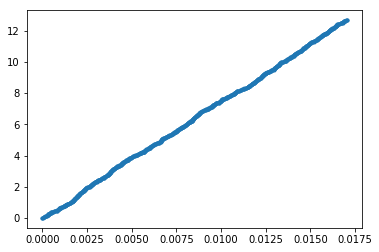

In [17]:
plt.plot(tDNS[key][:1000],lDNS[key][:1000],'.--')

#### Overview of the rough DNS time

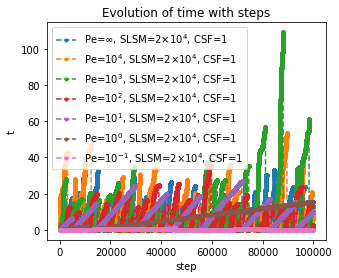

In [18]:
fig, axs = plt.subplots(1,1, figsize=(5,4), sharey = True)
ax = axs
ax.set_title('Evolution of time with steps');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(100000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();

In [19]:
crossing_time = {}
crossing_step = {}
for key in tDNS :
    crossing_time[key] = []
    crossing_step[key] = []
    t0  = -100
    cnt = 0
    for t1 in tDNS[key] :
        if t1 < t0 :
            crossing_time[key].append(t0)
            crossing_step[key].append(cnt)
            t0  = -1
            cnt = 0
        else :
            t0 = t1
            cnt += 1
    crossing_time[key] = np.array(crossing_time[key])
    crossing_step[key] = np.array(crossing_step[key])

In [20]:
crossing_time_pdf = {key : Extract_pdf(crossing_time[key],50) for key in KEYS}
crossing_step_pdf = {key : Extract_pdf(crossing_step[key],50) for key in KEYS}

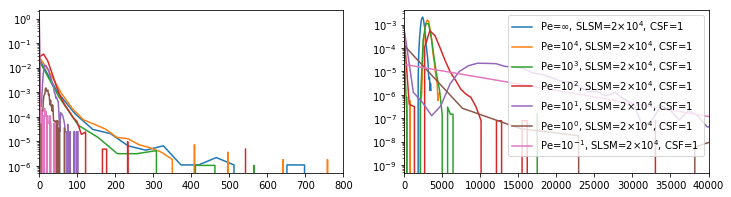

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
ax = axs[0]
for key in crossing_time_pdf :
    ax.semilogy(crossing_time_pdf[key][0],crossing_time_pdf[key][1], label = key);
#ax.legend();
ax.set_xlim([-1,800])
ax = axs[1]
for key in crossing_step_pdf :
    ax.semilogy(crossing_step_pdf[key][0],crossing_step_pdf[key][1], label = key);
ax.legend();
ax.set_xlim([-1,40000]);

#### Distribution of time step 

In [6]:
dt_histfname = ODIR+'dt_hist.dat'
dtmeanfname  = ODIR+'dt_mean.dat'
dtstdfname   = ODIR+'dt_std.dat'
dt_hist = {}; dtDNS_mean = {}; dtDNS_std = {};
print('Loading data...')
if os.path.isfile(dt_histfname) : dt_hist    = Load_pdf(dt_histfname)
if os.path.isfile(dtmeanfname)  : dtDNS_mean = Load_data(dtmeanfname)
if os.path.isfile(dtstdfname)   : dtDNS_std  = Load_data(dtstdfname)
print('Done.')

RESAVE = False
for key in KEYS :
    if (key not in dt_hist) or (key not in dtDNS_mean) or (key not in dtDNS_std) or RERUN:
        RESAVE = True
        print("missing " + key + " data..")        
        k_,h_,m_,s_ = time_step_analysis(tDNS[key],key)
        dt_hist[key]    = h_.tolist()
        dtDNS_mean[key] = [m_]
        dtDNS_std[key]  = [s_]
        
if RESAVE :
    print('Saving '+dt_histfname+'...')
    Save_pdf(dt_hist,dt_histfname)
    print('Saving '+dtmeanfname+'...')
    Save_data(dtDNS_mean,dtmeanfname)
    print('Saving '+dtstdfname+'...')
    Save_data(dtDNS_std,dtstdfname)
    print('Done.') 

Loading data...
Done.


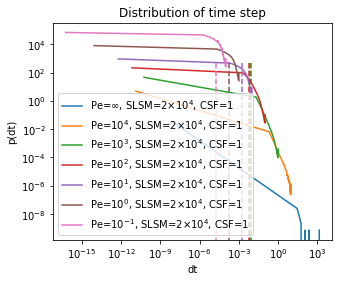

In [23]:
fig, axs = plt.subplots(1,1,figsize=(5,4))
ax = axs
k_ = 0
for key in KEYS:
    ax.plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    ax.plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
ax.set_title('Distribution of time step');
ax.set_xlabel('dt')
ax.set_ylabel('p(dt)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

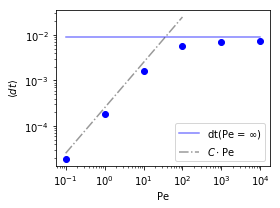

In [14]:
fig, axs = plt.subplots(1,1,figsize=(4,3))
ax = axs
ax.plot(PECLET[1:],[dtDNS_mean[k_][0]/PARAM[k_]['CSF'] for k_ in KEYS[1:]],'ob')
x_ = np.logspace(-1,4,10)
ax.plot(x_,[dtDNS_mean[KEYS[0]] for k_ in x_],'-b', alpha = 0.5, label = 'dt(Pe = '+v_to_pow(PECLET[0])+')')
x_ = np.linspace(0.1,100, 10)
y_ = 2*x_*(1.5e-6/UREF/TREF)**2
ax.plot(x_,y_,'-.k', alpha = 0.4, label = r'$C\cdot \mathrm{Pe}$')
ax.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Pe')
ax.set_ylabel(r'$\langle dt \rangle$')
ax.legend()
plt.tight_layout()
plt.savefig(FDIR+'DNS_dt_distribution.pdf')
plt.savefig(FDIR+'DNS_dt_distribution.png')

## Making DNS data isochronous

#### Isochronous transform of DNS data

In [25]:
#Single stream line transform
def ssl_transform(N,tDNS,vDNS) :
    t_ssl   = []
    v_ssl   = []
    told    = tDNS[0]
    T       = 0
    for  (t_,v_) in zip(tDNS,vDNS) :
        if t_ >= told :
            T += t_ - told
            t_ssl.append(T)
            v_ssl.append(v_)
        told = t_
    return np.array(t_ssl), np.array(v_ssl)

#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v

#Alternative version (parallel over dict keys) :
def isochronous_transform(t_, v_, dt, key, Npoints, ssltrans = True) :
    if ssltrans : t_serie, v_serie = ssl_transform (len(t_),t_, v_)
    if Npoints == 'all' :
        N = len(t_serie)-1
    elif 0 < Npoints <= 1 :
        N = int(Npoints * (len(t_serie)-1))
    else :
        N = Npoints
    Nt_iso   = int((t_serie[N]-t_serie[0])/dt)
    v_iso    = np.zeros(Nt_iso)
    m = 0; i = 0; ti = t_serie[0];
    while(m < N) :
        t1 = t_serie[m+1]; t0 = t_serie[m]
        v1 = v_serie[m+1]; v0 = v_serie[m]
        while (t0 <= ti <= t1) and (i < Nt_iso) :
            v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
            #v_iso.append(lin_interp(v1,t1,v0,t0,ti))
            ti += dt; i += 1
        m = m + 1
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor, MISSING_KEYS) :
    v_iso    = Parallel(n_jobs=NCORES_MAX)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key][0] * dt_factor, key, Npoints) for key in MISSING_KEYS)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

def sequential_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor, MISSIN_KEYS) :
    v_iso = [isochronous_transform(t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in MISSIN_KEYS]
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

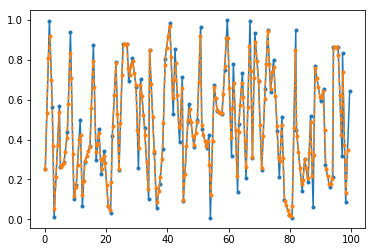

In [26]:
N_ = 100
y_ = rdm.rand(N_)
t_ = [rdm.rand(1)[0] + i for i in range(N_)]
dt_ = 0.5
key, y_iso_ = isochronous_transform(t_, y_, dt_, 'test', 'all')
t_iso_ = [t_[0]+i*dt_ for i in range(len(y_iso_))]
plt.plot(t_,y_,'.-')
plt.plot(t_iso_, y_iso_,'--.')

In [27]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso     = {}; 
theta_iso = {}
t_iso     = {} #time (linspace(0,T,dt))
Nt_iso    = {} #number of points
dt_iso    = {}; 
Npoints   = 'all'

#### Velocity isochronous transform

In [28]:
vname     = ODIR+'v_iso.dat'
if  os.path.isfile(vname) and (not RERUN):
    print('Loading v_iso.dat...')
    v_iso = Load_data(vname)

RESAVE_V     = False
iso_missing = {}
MISSING_KEYS = []
for key in KEYS : 
    if key not in v_iso :
        RESAVE_V = True
        #print('Missing '+key+' in v_iso..')
        MISSING_KEYS.append(key)

if MISSING_KEYS :
    start = time.time()
    iso_missing  = parallel_isochronous_transform(tDNS, vDNS, dtDNS_mean, Npoints, dt_factor, MISSING_KEYS)
    for key in MISSING_KEYS :
        #print('Missing '+key+' in v_iso..')
        #k_, v_iso[key] = isochronous_transform(tDNS[key], vDNS[key], dtDNS_mean[key], key, Npoints, ssltrans = True)
        v_iso[key] = iso_missing[key]
    end = time.time()
    iso_missing = {}
    print('\tTime needed \t: '+str(end-start))

Loading v_iso.dat...
	Time needed 	: 150.92390036582947


In [29]:
if RESAVE_V :
    print('Saving '+vname+'...')
    tosave = {k_ : v_iso[k_] for k_ in KEYS}
    Save_data(tosave,vname)
tosave = {}

Saving D:/pdm_data/Processed_data/v_iso.dat...


In [30]:
dtname    = ODIR+'dt_iso.dat'
if  os.path.isfile(dtname) and (not RERUN) :
    print('Loading dt_iso.dat...')
    dt_iso = Load_data(dtname)

for key in KEYS :
    print(key+' :')
    Nt_iso[key]  = len(v_iso[key])
    dt  = dtDNS_mean[key][0]
    dt_iso[key] = [dt]

Save_data(dt_iso,dtname)

Loading dt_iso.dat...
Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1 :
Pe=$10^{-1}$, SLSM=2$\times 10^{4}$, CSF=1 :


#### Theta equidistant transform

In [31]:
def ssl_transform_2(dlDNS, tDNS, vDNS ):
    l_ = 0
    v_ = vDNS[0]
    lssl = [l_]
    vssl = [v_]
    for i in range(len(dlDNS)-1) :
        if tDNS[i+1] > tDNS[i] :
            l_ += dlDNS[i]
            v_  = vDNS[i]
            lssl.append(l_)
            vssl.append(v_)
    dl = np.mean(np.array(lssl[1:])-np.array(lssl[:-1]))
    print(l_/dl)
    print(np.shape(vssl))
    return lssl, vssl, dl

def equidistant_transform_2 (dlDNS, tDNS, vDNS, key):
    l, v, dl = ssl_transform_2(dlDNS, tDNS, vDNS)
    N     = len(l)
    N_eq_ = int(l[-1]/dl)
    l_eq_ = 0
    v_eq_ = np.zeros(N_eq_)
    i = 0; j = 0;
    while j < N-1 :
        v1 = v[j+1]; v0 = v[j]
        l1 = l[j+1]; l0 = l[j]
        while l0 <= l_eq_ <= l1 and i < N_eq_ :
            v_eq_[i] = v0 + (v1-v0) * (l_eq_-l0)/(l1-l0)
            l_eq_ += dl
            i += 1
        j += 1
    return v, v_eq_, dl, key

def equidistant_transform (dlDNS, tDNS, vDNS, key):
    l, v, dl = ssl_transform_2(dlDNS, tDNS, vDNS)
    N     = len(l)
    N_eq_ = int(l[-1]/dl)
    l_eq_ = 0
    v_eq_ = np.zeros(N_eq_)
    i = 0; j = 0;
    while j < N-1 :
        v1 = v[j+1]; v0 = v[j]
        l1 = l[j+1]; l0 = l[j]
        while l0 <= l_eq_ <= l1 and i < N_eq_ :
            v_eq_[i] = v0 + (v1-v0) * (l_eq_-l0)/(l1-l0)
            l_eq_ += dl
            i += 1
        j += 1
    return v_eq_, dl

def parallel_equidistant_transform(dlDNS_dict, tDNS_dict, vDNS_dict, MISSING_KEYS) :
    results = Parallel(n_jobs=NCORES_MAX)(
        delayed(equidistant_transform_2)
        (dlDNS_dict[key], tDNS_dict[key], vDNS_dict[key], key) for key in MISSING_KEYS)
    vssl_dict = {}
    v_eq_dict = {}
    dl_eq_dict = {}
    for (vssl_, v_eq_, dl_, key_) in results :
        vssl_dict[key]  = vssl_
        v_eq_dict[key] = v_eq_.tolist()
        dl_eq_dict[key] = dl_
    return vssl_dict, v_eq_dict, dl_eq_dict

In [32]:
lssl  = {}; theta_ssl = {}
dl_eq = {}; theta_eq = {} 

theta_eqname= ODIR+'theta_eq.dat'
if  os.path.isfile(theta_eqname) and (not RERUN) :
    theta_eq = Load_data(theta_eqname)
    
dl_eqname= ODIR+'dl_eq.dat'
if  os.path.isfile(dl_eqname) and (not RERUN) :
    dl_eq = Load_data(dl_eqname)
    
MISSING_KEYS = []
for key in KEYS :
    if key not in theta_eq :
        MISSING_KEYS.append(key)

#theta_ssl, theta_eq, dl_eq = parallel_equidistant_transform (dlDNS, tDNS, thetaDNS, MISSING_KEYS)
for key in MISSING_KEYS :
    print(key)
    theta_eq[key], dl_eq[key] = equidistant_transform (dlDNS[key], tDNS[key], thetaDNS[key], 'test')
    

Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1
59936676.0
(59936677,)


In [ ]:
print('Saving '+theta_eqname+'...')
Save_data(theta_eq,theta_eqname)

In [38]:
print('Saving '+dl_eqname+'...')
tosave = {k_ :[dl_eq[k_].tolist()] for k_ in dl_eq}
Save_data(tosave,dl_eqname)
tosave = {}
print('Done.')

Saving D:/pdm_data/Processed_data/dl_eq.dat...
Done.


In [39]:
print(dl_eq[KEYS[0]]*len(theta_eq[KEYS[0]]))
print(np.sum(dlDNS[KEYS[0]]))

[742640.21261967]
742640.2539221625


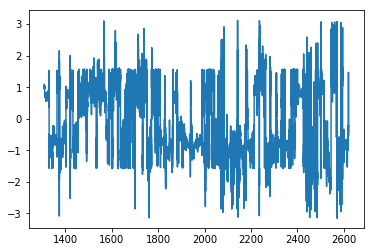

In [64]:
key = KEYS[-1]
N0  = 100000
Np  = 100000
plt.plot([i*dl_eq[key] for i in range(N0,N0+Np)],theta_eq[key][N0:N0+Np],'-');

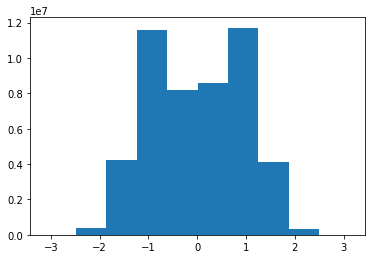

In [41]:
plt.hist(theta_eq[key]);

#### Verification of the isochronous transform by comparing it to original data

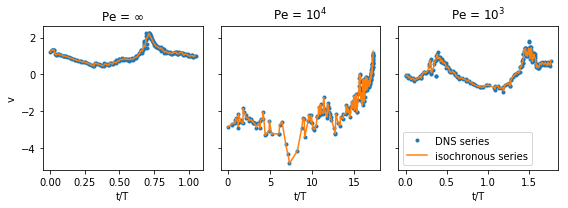

In [47]:
key    = KEYS[0]
fig, axs = plt.subplots(1,3, figsize = (8,3.0), sharey = True)
i0  = 0
N   = 200
for (i,key) in zip(range(3),KEYS) :
    axs[i].set_title('Pe = '+v_to_pow(PECLET[i]))
    axs[i].plot(tDNS[key][:N],vDNS[key][:N],'.', label = 'DNS series'); #rough DNS series

    T = tDNS[key][N]-tDNS[key][0]
    N_iso  = int(np.ceil(T/dt_iso[key]))
    t_iso  = [tDNS[key][0]+i_*dt_iso[key][0] for i_ in range(N_iso)]
    axs[i].plot(t_iso,v_iso[key][:N_iso],'-',label='isochronous series'); #Isochronous series

    axs[i].set_xlabel('t/T');
    axs[0].set_ylabel('v');
axs[i].legend();
plt.tight_layout()
plt.savefig(FDIR+'check_iso_transf'+extension)

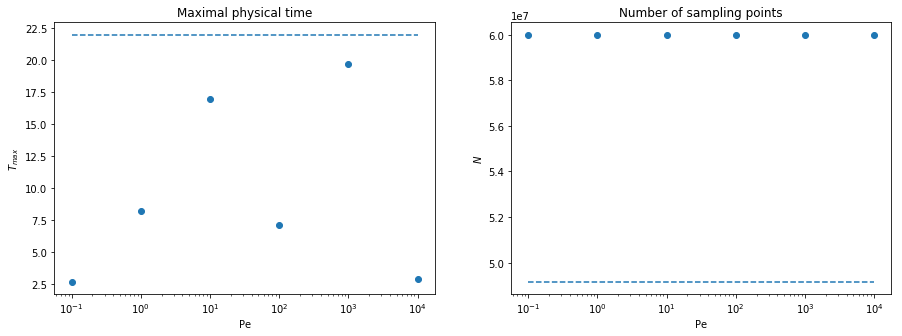

In [58]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey = False);
axs[0].set_title('Maximal physical time');
x_ = np.logspace(-1,4,10)
axs[0].semilogx(x_,[tDNS[KEYS[0]][-1] for k_ in x_],'--', color = color_cycle[0]);
axs[0].semilogx(PECLET[1:],[tDNS[k_][-1] for k_ in KEYS[1:]],'o', color = color_cycle[0]);
axs[0].set_xlabel(r'Pe');
axs[0].set_ylabel(r'$T_{max}$');

axs[1].set_title('Number of sampling points');
axs[1].semilogx(x_,[len(tDNS[KEYS[0]]) for k_ in x_],'--', color = color_cycle[0]);
axs[1].semilogx(PECLET[1:],[len(tDNS[k_]) for k_ in KEYS[1:]],'o', color = color_cycle[0]);
axs[1].set_xlabel(r'Pe');
axs[1].set_ylabel(r'$N$');

### Comparison with Markovian processes

In [59]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


#### Computation of LVM PDF

In [60]:
pdf_vDNS           = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname     = ODIR+'pdf_vDNS.dat'
pdf_viso           = {} #to store isochronous histogram as a line
pdf_viso_fname     = ODIR+'pdf_viso.dat'

pdf_thetaDNS       = {} #Directional angle probability density function extracted directly from DNS
pdf_thetaDNS_fname = ODIR+'pdf_thetaDNS.dat'
pdf_thetaiso       = {} 
pdf_thetaiso_fname = ODIR+'pdf_thetaiso.dat'
pdf_thetaeq        = {} 
pdf_thetaeq_fname  = ODIR+'pdf_thetaeq.dat'
pdf_thetaeq_abs   = {} 
pdf_thetaeq_abs_fname  = ODIR+'pdf_thetaeq_abs.dat'  

In [61]:
if os.path.isfile(pdf_vDNS_fname): 
    print('Loading vDNS pdf..')
    pdf_vDNS = Load_pdf(pdf_vDNS_fname)
    
if os.path.isfile(pdf_viso_fname): 
    print('Loading viso pdf..')
    pdf_viso = Load_pdf(pdf_viso_fname)
    
if os.path.isfile(pdf_thetaDNS_fname): 
    print('Loading thetaDNS pdf..')
    pdf_thetaDNS = Load_pdf(pdf_thetaDNS_fname)
    
if os.path.isfile(pdf_thetaiso_fname): 
    print('Loading thetaiso pdf..')
    pdf_thetaiso = Load_pdf(pdf_thetaiso_fname)

if os.path.isfile(pdf_thetaeq_fname): 
    print('Loading thetaeq pdf..')
    pdf_thetaeq = Load_pdf(pdf_thetaeq_fname)
    
if os.path.isfile(pdf_thetaeq_abs_fname):
    print('Loading thetaeq_abs pdf..')
    pdf_thetaeq_abs = Load_pdf(pdf_thetaeq_abs_fname)

Loading vDNS pdf..
Loading viso pdf..
Loading thetaDNS pdf..
Loading thetaiso pdf..
Loading thetaeq pdf..
Loading thetaeq_abs pdf..


In [67]:
SAVE = False
for key in KEYS :
    if key not in pdf_vDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_vDNS[key] = Extract_pdf(vDNS[key])
        pdf_viso[key] = Extract_pdf(v_iso[key])
    if key not in pdf_thetaDNS:
        SAVE= True
        print("missing " + key + " data in pdf_thetaDNS..")        
        pdf_thetaDNS[key] = Extract_pdf(np.abs([tt_ for tt_ in thetaDNS[key] if str(tt_) != 'nan']))

    if key not in pdf_thetaeq :
        SAVE= True
        print("missing " + key + " data ub pdf_thetaeq..")        
        pdf_thetaeq[key] = Extract_pdf([tt_ for tt_ in theta_eq[key] if str(tt_) != 'nan'])

    if key not in pdf_thetaeq_abs :
        SAVE= True
        print("missing " + key + " data in pdf_thetaeq abs..")        
        pdf_thetaeq_abs[key] = Extract_pdf(np.abs([tt_ for tt_ in theta_eq[key]if str(tt_) != 'nan']))


if SAVE :     
    print('\tSaving..')
    Save_pdf(pdf_vDNS, pdf_vDNS_fname)
    Save_pdf(pdf_viso, pdf_viso_fname)
    Save_pdf(pdf_thetaDNS, pdf_thetaDNS_fname)
    Save_pdf(pdf_thetaiso, pdf_thetaiso_fname)
    Save_pdf(pdf_thetaeq, pdf_thetaeq_fname)
    Save_pdf(pdf_thetaeq_abs, pdf_thetaeq_abs_fname)
print('Done.')

missing Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{4}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaeq abs..
missing Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaeq abs..
missing Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaeq abs..
missing Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaeq abs..
missing Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaDNS..
missing Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaeq abs..
missing Pe=$10^{-1}$, SLSM=2$\times 10^{4}$, CSF=1 data in pdf_thetaDNS..
missing Pe=$10^{-1}$, SLSM=2$\times 10^{4}$, CSF=1 data ub pdf_thetaeq..
missing Pe=$10^{-1}$, SLSM=2$\times 10^{

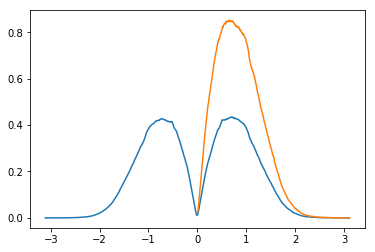

In [68]:
plt.plot(pdf_thetaeq[KEYS[0]][0],pdf_thetaeq[KEYS[0]][1]);
plt.plot(pdf_thetaeq_abs[KEYS[0]][0],pdf_thetaeq_abs[KEYS[0]][1]);

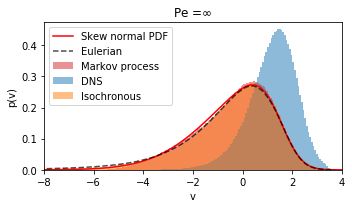

In [69]:
lvmpdf = Load_pdf(ODIR+'bentheimer1000lvmpdf.dat')
fig, ax = plt.subplots(1,1,figsize = (5,3.0), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in [PLOT_KEYS[0]]:
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    ax.set_title(r'Pe =$\infty$')
    ax.hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5, color = color_cycle[3])
    ax.hist(data1, bins = 200, label ='DNS',         density = True, alpha= 0.5, color = color_cycle[0])
    ax.hist(data2, bins = 200, label ='Isochronous', density = True, alpha= 0.5, color = color_cycle[1])
    ax.plot(vrange, p_skew(vrange,sample), label = 'Skew normal PDF', color = 'r');
    ax.plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Eulerian', alpha=0.7);
    #ax.grid(True)
    ax.set_xlabel('v')
    ax.set_ylabel('p(v)')
    ax.legend()
    ax.set_xlim([-8,4])
plt.tight_layout()
plt.savefig(FDIR+'LVM_pdf_DM=0'+extension)

#### Autocorrelation

We compute autocorrelation using the normalized estimator : 
$$\hat R(k) = \frac{1}{n-k} \sum_{t=1}^{n-k} \left(\frac{X_t-\mu_Y}{\sigma_X}\right)\left(\frac{Y_t-\mu_Y}{\sigma_Y}\right) \quad\textrm{where}\quad \{Y_1,Y_2,...,Y_{n-k}\} := \{X_{k+1},X_{k+2},...,X_{n}\} $$

The cutting time $\tau_c$ that approach the distance between two closest uncorrelated measures is defined as the time where the tangent at $R(t_k=0)$ crosses the x-axis. 
This tangent is approximated as an $m$ points average slope as

$$ \partial R/\partial t|_{t_k=0} \approx \frac{R(t_m)-R(0)}{t_m - t_0} $$
leading to
$$ \tau_c = \frac{\Delta R}{\partial R/\partial t} \approx \frac{R(t_k=\tau_c)-R(t_k=0)}{(R(t_k=t_m) - R(t_k=0))/(t_m - t_0)}. $$

Per definition, $R(\tau_c)=0$ and $R(t_0=0)=1$ so the expression reduces to
$$ \tau_c = \frac{-t_m}{R(t_k=t_m)-1} $$

In [71]:
def autocorr_hm(x, Kmax, Nwidth, Np, key, exp) :
    x = np.array(x)
    x = x[~np.isnan(x)]
    if exp :
        x = np.exp(x)
    print(key + ': Nwidth = '+ v_to_pow(Nwidth) + ', Kmax = '+v_to_pow(Kmax))
    N     = min(len(x),int(Nwidth))
    Nskip = int(Kmax/Np)
    
    acf   = np.zeros(Np)
    krange= np.zeros(Np)
    i     = 0
    for i in range(Np):
        k = i*Nskip
        mut      = np.mean(x[:N-k])
        mutpk    = np.mean(x[k:N])
        sigmat   = np.std (x[:N-k])
        sigmatpk = np.std (x[k:N])
        for t in range(N-k):
            acf[i] += 1.0/(N-k)*(x[t]-mut)/sigmat*(x[t+k]-mutpk)/sigmatpk
        krange[i] = k
    return (key, krange, acf) 

def sequential_autocorr(v_dict, dt_dict, Tmax, Nwidth = 1000, Np = 50, exp = False) :
    v_autocorr = {}
    k_autocorr = {}
    results = [autocorr_hm(v_dict[key], int(Tmax/dt_dict[key]), Nwidth, Np, key, exp) for key in v_dict]
    for (key, k_, v_) in results :
        k_autocorr[key] = k_
        v_autocorr[key] = v_
    return (k_autocorr,v_autocorr)

def parallel_autocorr(v_dict, dt_dict, Tmax, Nwidth = 1000, Np = 50, exp = False) :
    v_autocorr = {}
    k_autocorr = {}
    results = Parallel(n_jobs=NCORES_MAX)(delayed(autocorr_hm)(v_dict[key], int(Tmax/dt_dict[key][0]), Nwidth, Np, key, exp) for key in v_dict)
    for (key, k_, v_) in results :
        k_autocorr[key] = k_
        v_autocorr[key] = v_
    return (k_autocorr,v_autocorr)

def l_theta_range(v_iso, dt_, t_autocorr) :
    Np = len(t_autocorr)
    N_ = [int(tt_/dt_) for tt_ in t_autocorr]
    n_ = 0
    l_range = np.zeros(Np)
    l_ = 0
    for i_ in range(N_[-1]) :
        if (i_ in N_) :
            l_range[N_.index(i_)]=(l_)
        l_ += np.exp(v_iso[i_]) * dt_
    return l_range

def extract_cutting_time(x, acf, Np = 10) :
    tau = -x[Np]/(acf[Np]-1)
    return tau

### $v(t)$ autocorrelation

In [72]:
v_autocorr = {}; vautocorrfname = ODIR+'v_autocorr.dat'
kv_autocorr = {}; kvautocorrfname = ODIR+'kv_autocorr.dat'
RERUN_V    = True
NCORES_MAX = 4
if os.path.isfile(vautocorrfname) and (not RERUN_V): 
    v_autocorr = Load_data(vautocorrfname)
    kv_autocorr = Load_data(kvautocorrfname)
else :
    RERUN_V = True
if RERUN_V :
    print('Computing U autocorrelation..')
    Tmax  = 12.0
    Nwidth= 1e6 
    Np    = 100
    start = time.time()
    kv_autocorr, v_autocorr = parallel_autocorr(v_iso, dt_iso, Tmax, Nwidth, Np, True)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))    
    print('Saving..')
    Save_data(v_autocorr, vautocorrfname)
    Save_data(kv_autocorr, kvautocorrfname)
print('Done.')

Computing U autocorrelation..
	Time needed : 158.82733869552612
Saving..
Done.


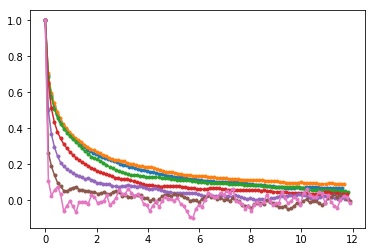

In [73]:
for key in KEYS :
    plt.plot(kv_autocorr[key]*dt_iso[key][0], v_autocorr[key], '.-', label = key)

### $\theta(l)$ autocorrelation

In [74]:
theta_autocorr = {}; thetaautocorrfname = ODIR+'theta_autocorr.dat'
kt_autocorr = {}; ktautocorrfname = ODIR+'kt_autocorr.dat'
l_autocorr = {}; lautocorrfname = ODIR+'l_autocorr.dat'

RERUN_THETA= True
if os.path.isfile(thetaautocorrfname) and (not RERUN_THETA): 
    theta_autocorr = Load_data(thetaautocorrfname) 
    kt_autocorr    = Load_data(ktautocorrfname)
else : 
    print('Computing theta autocorrelation..')
    Lmax  = 100.0
    Nwidth= 1e7
    Np    = 40
    start = time.time()
    kt_autocorr, theta_autocorr = parallel_autocorr(theta_eq, {key:[dl_eq[key]] for key in dl_eq}, Lmax, Nwidth, Np, False)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))  
    print('Saving..')
    Save_data(theta_autocorr, thetaautocorrfname)
    Save_data(kt_autocorr, ktautocorrfname)
print('Done.')

Computing theta autocorrelation..
	Time needed : 523.0605382919312
Saving..
Done.


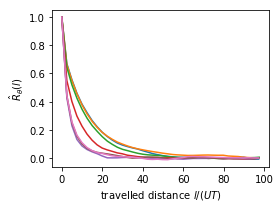

In [75]:
plt.figure(figsize=(4, 3))
for key in KEYS :
    plt.plot(kt_autocorr[key]*dl_eq[key], theta_autocorr[key], '-', label = key)
plt.xlabel(r'travelled distance $l/(UT)$')
plt.ylabel(r'$\hat{R}_\theta(l)$')
#plt.xlim([0,80])
#plt.ylim([0,1.0])
plt.tight_layout()
plt.savefig(FDIR+'autocorelation_theta'+extension)

In [76]:
L_t_pdf = {}
for key in KEYS :
    L_t = []
    cnt = 0
    t_old = theta_eq[key][0]
    for t_new in theta_eq[key][1:] :
        if ((t_new * t_old) < 0 and cnt > 0) :
            L_t.append(cnt*dl_eq[key])
            cnt = 0
        else :
            cnt += 1
        t_old = t_new
        
    L_t_pdf[key] = Extract_pdf(L_t)
Save_pdf(L_t_pdf, ODIR+'L_t_pdf.dat' )

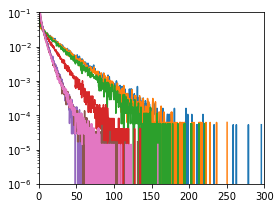

In [77]:
plt.figure(figsize=(4, 3))
for key in KEYS : plt.plot(L_t_pdf[key][0], L_t_pdf[key][1],'-')
plt.yscale('log')
plt.xlim([0,300])
plt.ylim([1e-6,1e-1])
plt.tight_layout()
plt.savefig(FDIR+'travel_distance_Ltheta'+extension)

In [78]:
print(UREF*TREF/LPORE)
print(UREF*TREF)

1.0118773333333335
0.00013432


###  Compensated variance evolution (CVE)
$$
\langle [\beta(l+s) - \beta (l)]^2\rangle/s
$$

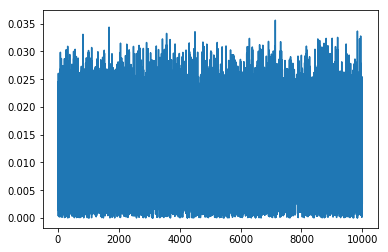

In [79]:
plt.plot(dlDNS[key][:10000])

In [94]:
betaDNS = {};
for key in KEYS :
    betaDNS[key] = np.zeros(len(tDNS[key]))
    b_ = 0
    for i in range(len(dbetaDNS[key])) :
        b_ += dbetaDNS[key][i]
        betaDNS[key][i+1] = b_

In [109]:
for key in KEYS : 
    dl_eq[key] = np.mean(dlDNS[key])

In [108]:
#Construction of an equidistant version of betaDNS
if False : #os.path.isfile(ODIR + 'beta_eq.dat') : 
    print('Loading data..')
    beta_eq = Load_data(ODIR + 'beta_eq.dat')
else :
    beta_eq = {}
    for key in KEYS :
        dl_ = np.mean(dlDNS[key])
        beta_eq[key] = [betaDNS[key][0]]
        l_i = dl_
        for b1_, b0_, l1_, l0_, in zip(betaDNS[key][1:],betaDNS[key][:-1],lDNS[key][1:],lDNS[key][:-1]) :
            while (l0_ <= l_i <= l1_) :
                beta_eq[key].append(lin_interp(b1_,l1_,b0_,l0_,l_i))
                l_i += dl_
    Save_data(beta_eq, ODIR + 'beta_eq.dat')

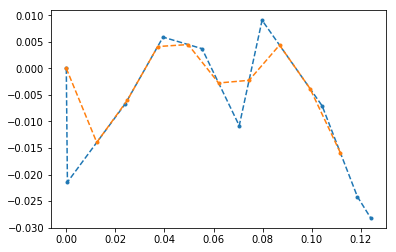

In [112]:
Np = 10
plt.plot(lDNS[key][:Np], betaDNS[key][:Np],'.--')
plt.plot([i*dl_eq[key] for i in range(Np)], beta_eq[key][:Np],'.--');

In [113]:
def compute_cve(beta_, dl_eq, Nmax = 1000, Np= 20) :
    N_   = len(beta_)
    lmax = dl_eq * N_
    lmin = dl_eq
    NL = np.logspace(np.log10(2), np.log10(Nmax), Np)
    S  = dl_eq * NL
    CVE = np.zeros(Np)
    for i in range(Np) :
        s_ = S[i]
        ks_= int(NL[i])
        CVE[i] = np.mean((beta_[ks_:]-beta_[:-ks_])**2)/s_
    return S, CVE

In [118]:
CVE = {}; S = {}
if os.path.isfile(ODIR + 'CVE.dat'):
    CVE = Load_data(ODIR + 'CVE.dat')
    S   = Load_data(ODIR + 'S.dat')
else:
    for key in KEYS :
        Nmax = 5e2/dl_eq[key]
        S[key], CVE[key] = compute_cve(np.array(beta_eq[key]), dl_eq[key], Nmax)
        Save_data(CVE, ODIR + 'CVE.dat')
        Save_data(S, ODIR + 'S.dat')

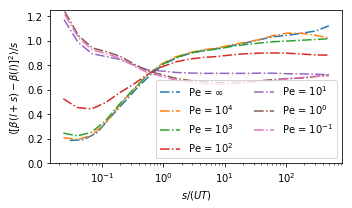

In [139]:
plt.figure(figsize=(5,3))
for key,Pe_ in zip(KEYS,PECLET) : plt.semilogx(S[key],CVE[key],'-.',label='Pe = ' + v_to_pow(Pe_));
plt.xlabel(r'$s/(UT)$')
plt.ylim([0,1.25])
plt.ylabel(r'$\langle [\beta(l+s) - \beta(l)]^2\rangle /s$')
#plt.xlim([1e-2,8e2]);
plt.legend(ncol = 2);
plt.tight_layout()
plt.savefig(FDIR+'compensated_variance_evolution.pdf')
plt.savefig(FDIR+'compensated_variance_evolution.png')

In [120]:
for key in KEYS : print(np.mean(beta_eq[key]))

-1856.9014495639467
-1418.4503355605896
-1140.2284181640139
360.8861545798423
240.8938375281573
350.6169375814491
-114.91845923301317


In [121]:
print(np.mean(dbeta_eq[key]))
print(np.sum(dbetaDNS[key]))

NameError: name 'dbeta_eq' is not defined